In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 511 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 7.6 MB/s 
  Created wheel for openai: filename=openai-0.25.0-py3-none-any.whl size=55881 sha256=f1ba7587fe202fb21ec8ae4f24011f24218c3dac829b4283a2297d9293c68ad9
  Stored in directory: /root/.cache/pip/wheels/19/de/db/e82770b480ec30fd4a6d67108744b9c52be167c04fcf4af7b5
Successfully built openai


In [ ]:
import random
from itertools import product
import openai
from PIL import Image
import requests
from io import BytesIO
import numpy as np

openai.api_key = 'ADD_OPEN_AI_KEY_HERE'

In [ ]:
def get_random_code(length=4, n_choices=3):
  return [random.randint(0, n_choices-1) for _ in range(length)]


def score_guess(actual, guess):

  right_spot = 0
  ints_guessed = {}
  ints_in_code = {}

  for i in range(len(actual)):
    if actual[i] == guess[i]:
      right_spot += 1
    else:
      ints_guessed[guess[i]] = ints_guessed.get(guess[i], 0) + 1
      ints_in_code[actual[i]] = ints_in_code.get(actual[i], 0) + 1

  wrong_spot = 0
  for val in set(guess):
    wrong_spot += min(ints_guessed.get(val, 0), ints_in_code.get(val, 0))

  return right_spot, wrong_spot


code_to_color = {}
code_to_color[0] = 'red'
code_to_color[1] = 'green'
code_to_color[2] = 'blue'

color_to_code = {}
color_to_code['red'] = 0
color_to_code['green'] = 1
color_to_code['blue'] = 2


def code_to_colors(code):
  return [code_to_color[x] for x in code]


class RandomAgent:

  def __init__(self, code_length, n_categories):
    self.remaining_guesses = set()
    self.n_guesses = 0

    for combination in product([i for i in range(n_categories)], repeat=code_length):
      self.remaining_guesses.add(combination)

  def get_guess(self):
    guess = random.sample(self.remaining_guesses, 1)[0]
    self.remaining_guesses.remove(guess)
    self.n_guesses += 1

    return list(guess)

  def update_remaining_guesses(self, guess, score):
    new_set = set()
    for code in self.remaining_guesses:
      new_score = score_guess(guess, list(code))
      if new_score == score:
        new_set.add(code)
    self.remaining_guesses = new_set

  def get_n_guesses(self):
    return self.n_guesses



In [ ]:
def get_image(color):
  url = openai.Image.create(
    prompt="one smooth {} ball on a plain white background".format(color),
    n=1,
    size="256x256"
  )['data'][0]['url']

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))

  return np.array(img)


def get_images(color1, color2, color3, color4):
  img1 = get_image(color1)
  img2 = get_image(color2)
  img3 = get_image(color3)
  img4 = get_image(color4)

  img = np.zeros((256,1024,3))
  img[:256,:256] = img1
  img[:256:,256:512] = img2
  img[:256,512:768] = img3
  img[:256,768:1024] = img4

  return Image.fromarray(img.astype('uint8'))
  

def get_guess_from_image(img):
  guess1 = np.array(img)[:256, :256].mean(axis=(0,1)).argmax()
  guess2 = np.array(img)[:256, 256:512].mean(axis=(0,1)).argmax()
  guess3 = np.array(img)[:256, 512:768].mean(axis=(0,1)).argmax()
  guess4 = np.array(img)[:256, 768:].mean(axis=(0,1)).argmax()
  
  return [guess1, guess2, guess3, guess4]

Code is:  ['red', 'red', 'blue', 'green']

Guess:  ['red', 'green', 'green', 'green']


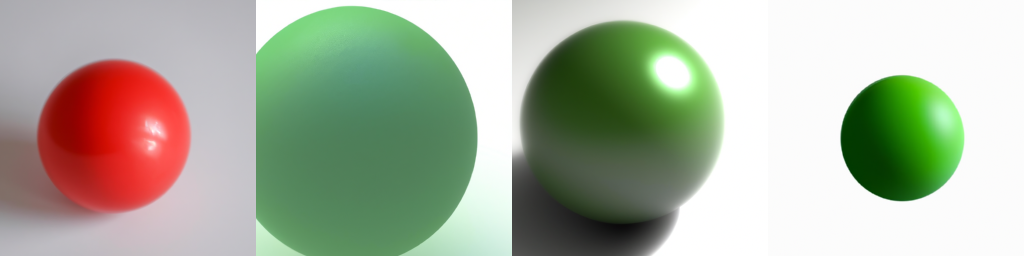

Guess from image:  ['red', 'green', 'green', 'green']
Score:  (2, 0)

Guess:  ['red', 'green', 'blue', 'red']


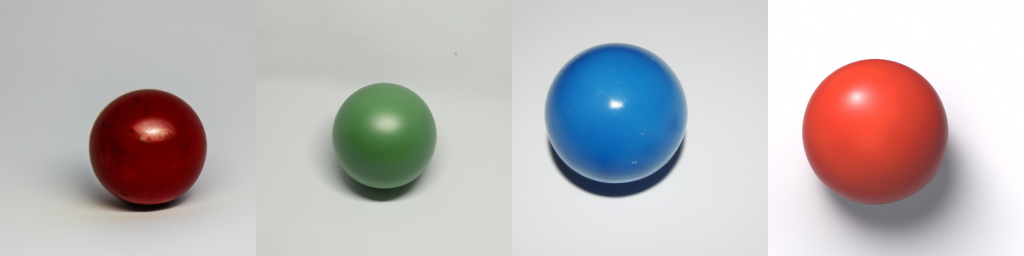

Guess from image:  ['red', 'green', 'blue', 'red']
Score:  (2, 2)

Guess:  ['red', 'red', 'blue', 'green']


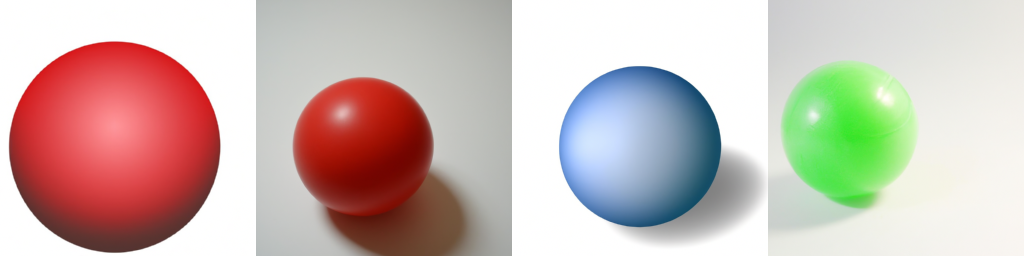

Guess from image:  ['red', 'red', 'blue', 'green']
Score:  (4, 0)

Correctly guessed the code!


In [ ]:
CODE_LENGTH = 4
CODE_CATEGORIES = 3

code_guessed = False
code = get_random_code(CODE_LENGTH, CODE_CATEGORIES)
print("Code is: ", code_to_colors(code))
print()

agent = RandomAgent(CODE_LENGTH, CODE_CATEGORIES)
images_of_guesses = []

while not code_guessed:
  guess = agent.get_guess()
  guess_colors = code_to_colors(guess)
  image_of_guess = get_images(guess_colors[0], guess_colors[1], guess_colors[2], guess_colors[3])
  images_of_guesses.append(image_of_guess)
  guess_from_image = get_guess_from_image(image_of_guess)

  print("Guess: ", guess_colors)
  display(image_of_guess)
  print("Guess from image: ", code_to_colors(guess_from_image))

  score = score_guess(code, guess_from_image)
  agent.update_remaining_guesses(guess, score)

  print("Score: ", score)
  print()

  if score == (CODE_LENGTH, 0):
    code_guessed = True
    print("Correctly guessed the code!")

  if len(images_of_guesses) > 8:
    print("Code not found within 8 guesses.")
    break